In [1]:
# Partially from https://github.com/borutb-fri/FMLD/blob/main/mask-test.py

import os
import torch
from torchvision import transforms, datasets
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_ds(root):
    # Applying Transforms to the Data
    image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
    
    directories = {
        type_: os.path.join(root, type_) for type_ in next(os.walk(root))[1]
    }
    types = directories.keys()

    # Batch size
    bs = 128

    # Number of classes
    num_classes = 2

    # Load Data from folders
    ds = {
        type_: datasets.ImageFolder(root=directories[type_], transform=image_transform)
                                    for type_ in  directories
    }
    
    dls = {type_: torch.utils.data.DataLoader(ds[type_], batch_size=bs, shuffle=(True*type_!="test"), num_workers=4)
              for type_ in types
    }
    dls = {type_: {"dl": dls[type_], "size": len(ds[type_])} for type_ in types}
    return dls

In [3]:
data_loaders = get_ds('_FULL'); data_loaders

StopIteration: 

Number of faces:  10482
Test accuracy:  0.9732875405798157
Test precision: 0.9841006955945677
Test recall:    0.969964087495919


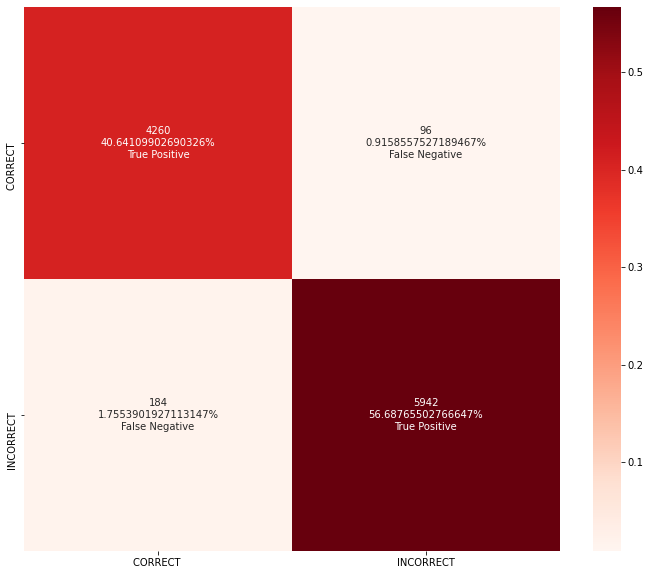

In [53]:
# Print the test set data sizes
data_size = data_loaders["test"]["size"]
data_loader = data_loaders["test"]["dl"]

print('Number of faces: ',data_loaders["test"]["size"])

def TestM(model, loss_criterion, data_loader, data_size):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    test_acc = 0.0
    test_loss = 0.0
    class_expected = []
    class_real = []
    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            class_expected.extend(labels)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            #loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            #test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            class_real.extend(predictions.numpy())
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)
    avg_test_acc = test_acc/data_size
    return avg_test_acc, {"exp": class_expected, "real": class_real}



device = torch.device('cpu')
loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 

model = torchvision.models.mobilenet_v3_small(pretrained=True)
model.fc = nn.Linear(1024, 2)

model_file = 'models/mobilenet_v3_small_1_Linear_10e_FULL.pt'
if not os.path.exists(model_file):
    print("Can not find model {model_file}")
else:
    model.load_state_dict(torch.load(model_file))
    model = model.to(device)
    avg_test_acc, res = TestM(model, loss_func, data_loaders["test"]["dl"], data_loaders["test"]["size"])
    print("Test accuracy:  " + str(avg_test_acc))
    print("Test precision: " + str(precision_score(res["exp"], res["real"])))
    print("Test recall:    " + str(recall_score(res["exp"], res["real"])))
    classes = ["CORRECT ", "INCORRECT"]
    cf_matrix = confusion_matrix(res["exp"], res["real"])
    vals = cf_matrix.flatten()
    prcs = (cf_matrix.flatten()/np.sum(vals))*100
    annots = ['True Positive','False Negative','False Negative','True Positive']
    lbls = [ f"{v}\n{p}%\n{a}" for v,p,a in zip(vals, prcs, annots) ]
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = classes, columns = classes)
    lbls = np.asarray(lbls).reshape(2,2)
    plt.figure(figsize = (12,10))
    sn.heatmap(df_cm, annot=lbls, fmt='', cmap='Reds')
